In [1]:
# Copyright (c) 2017-2019 Uber Technologies, Inc.
# SPDX-License-Identifier: Apache-2.0

import argparse
import logging

import torch

import pyro
import pyro.distributions as dist
from pyro.infer import SMCFilter

logging.basicConfig(format="%(relativeCreated) 9d %(message)s", level=logging.INFO)

"""
This file demonstrates how to use the SMCFilter algorithm with
a simple model of a noisy harmonic oscillator of the form:
    z[t] ~ N(A*z[t-1], B*sigma_z)
    y[t] ~ N(z[t][0], sigma_y)
"""


class SimpleHarmonicModel:

    def __init__(self, process_noise, measurement_noise):
        self.A = torch.tensor([[0., 1.],
                               [-1., 0.]])
        self.B = torch.tensor([3., 3.])
        self.sigma_z = torch.tensor(process_noise)
        self.sigma_y = torch.tensor(measurement_noise)

    def init(self, state, initial):
        self.t = 0
        state["z"] = pyro.sample("z_init", dist.Delta(initial, event_dim=1))

    def step(self, state, y=None):
        self.t += 1
        state["z"] = pyro.sample(
            "z_{}".format(self.t),
            dist.Normal(state["z"].matmul(self.A), self.B*self.sigma_z).to_event(1))
        y = pyro.sample("y_{}".format(self.t),
                        dist.Normal(state["z"][..., 0], self.sigma_y),
                        obs=y)
        return state["z"], y


class SimpleHarmonicModel_Guide:

    def __init__(self, model):
        self.model = model

    def init(self, state, initial):
        self.t = 0
        pyro.sample("z_init", dist.Delta(initial, event_dim=1))

    def step(self, state, y=None):
        self.t += 1

        # Proposal distribution
        pyro.sample(
            "z_{}".format(self.t),
            dist.Normal(state["z"].matmul(self.model.A), torch.tensor([1., 1.])).to_event(1))


def generate_data(args):
    model = SimpleHarmonicModel(args.process_noise, args.measurement_noise)

    state = {}
    initial = torch.tensor([1., 0.])
    model.init(state, initial=initial)
    zs = [initial]
    ys = [None]
    for t in range(args.num_timesteps):
        z, y = model.step(state)
        zs.append(z)
        ys.append(y)

    return zs, ys
    

In [3]:
parser = argparse.ArgumentParser(description="Simple Harmonic Oscillator w/ SMC Filtering Inference")
parser.add_argument("-n", "--num-timesteps", default=500, type=int)
parser.add_argument("-p", "--num-particles", default=100, type=int)
parser.add_argument("--process-noise", default=1., type=float)
parser.add_argument("--measurement-noise", default=1., type=float)
parser.add_argument("--seed", default=0, type=int)
args = parser.parse_args([])

In [4]:
model = SimpleHarmonicModel(args.process_noise, args.measurement_noise)
guide = SimpleHarmonicModel_Guide(model)

smc = SMCFilter(model, guide, num_particles=args.num_particles, max_plate_nesting=0)

logging.info("Generating data")
zs, ys = generate_data(args)

logging.info("Filtering")

smc.init(initial=torch.tensor([1., 0.]))
for y in ys[1:]:
    smc.step(y)

logging.info("At final time step:")
z = smc.get_empirical()["z"]
logging.info("truth: {}".format(zs[-1]))
logging.info("mean: {}".format(z.mean))
logging.info("std: {}".format(z.variance ** 0.5))

    90742 Generating data
    90842 Filtering
    91305 At final time step:
    91308 truth: tensor([124.2802,  55.4495])
    91309 mean: tensor([121.1711,  59.2241])
    91311 std: tensor([0.0735, 0.6319])


Text(0.5, 0, 'Time')

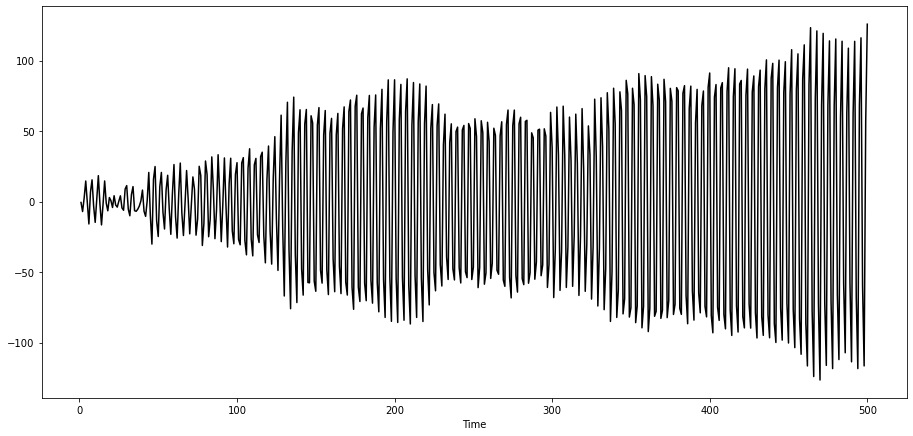

In [11]:
ys
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(15.5, 7.2))
ax.plot( ys, color='k' )
ax.set_xlabel('Time')

In [18]:
z.mean, z.variance

(tensor([121.1711,  59.2241]), tensor([0.0054, 0.3993]))